# Loading and shaping the Dataset

Import necessary libraries

In [ ]:
pip install ucimlrepo  #Library to fetch dataset directly from the link

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from ucimlrepo import fetch_ucirepo
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


In [ ]:
# fetch dataset
air_quality = fetch_ucirepo(id=360)

In [ ]:
# data (as pandas dataframes)
data_raw = air_quality.data.features

In [ ]:
data_raw

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


# Data Preprocessing

Check for missing values - no NaN values

In [ ]:
data = data_raw[data_raw != ""]
data = data.dropna()

In [ ]:
data.shape #After dropna, no NaN values

(9357, 15)

### Handle erroneous data

#### 'RH' (Relative Humidity)

In RH column;

The values should be in range 0-101 because it's represented with %.

Replace the invalid values with the mean of 'RH' data.

In [ ]:
out_of_bounds = (data['RH'] < 0) | (data['RH'] > 100) # Determine the RH values that not in range  0 <= value <= 100

data.loc[out_of_bounds,'RH'] = np.nan # Set that values NaN

data['RH'] = data['RH'].fillna(data['RH'].median()) # Fill the NaN values with the mean of the data (we can change the filling technique)

#### Other columns

Remaining columns (except 'T' - which will be inspected later on-) should be positive since they represent an amount.

Invalid values are replaced with the mean of corresponding columns.

In [ ]:
remaining_columns = ['AH','CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)']

for column in remaining_columns:
    data.loc[data[column] < 0,column] = np.nan # Set -200 values to NaN
    data[column] = data[column].fillna(data[column].median()) # Fill them with median

# Visualize the data, detect and handle outliers

In [ ]:
numeric_columns = data.columns[2:]
for column in numeric_columns:
    print(f"The maximum value in {column} : " ,data[column].max())
    print(f"The median of {column} : " ,data[column].median())
    print(f"The minimum value in {column} : " ,data[column].min())
    print()

The maximum value in CO(GT) :  11.9
The median of CO(GT) :  1.8
The minimum value in CO(GT) :  0.1

The maximum value in PT08.S1(CO) :  2040.0
The median of PT08.S1(CO) :  1063.0
The minimum value in PT08.S1(CO) :  647.0

The maximum value in NMHC(GT) :  1189.0
The median of NMHC(GT) :  150.0
The minimum value in NMHC(GT) :  7.0

The maximum value in C6H6(GT) :  63.7
The median of C6H6(GT) :  8.2
The minimum value in C6H6(GT) :  0.1

The maximum value in PT08.S2(NMHC) :  2214.0
The median of PT08.S2(NMHC) :  909.0
The minimum value in PT08.S2(NMHC) :  383.0

The maximum value in NOx(GT) :  1479.0
The median of NOx(GT) :  180.0
The minimum value in NOx(GT) :  2.0

The maximum value in PT08.S3(NOx) :  2683.0
The median of PT08.S3(NOx) :  806.0
The minimum value in PT08.S3(NOx) :  322.0

The maximum value in NO2(GT) :  340.0
The median of NO2(GT) :  109.0
The minimum value in NO2(GT) :  2.0

The maximum value in PT08.S4(NO2) :  2775.0
The median of PT08.S4(NO2) :  1463.0
The minimum value

Define a function that plots the given data's distribution:

In [ ]:
def plot_feature_distributions(data, columns):
    plt.figure(figsize=(15, 12))
    for i, column in enumerate(columns):
        plt.subplot(3, 4, i+1)  # Create subplots
        sns.histplot(data[column], bins=20, kde=True)
        plt.title(column)
    plt.tight_layout()
    plt.show()

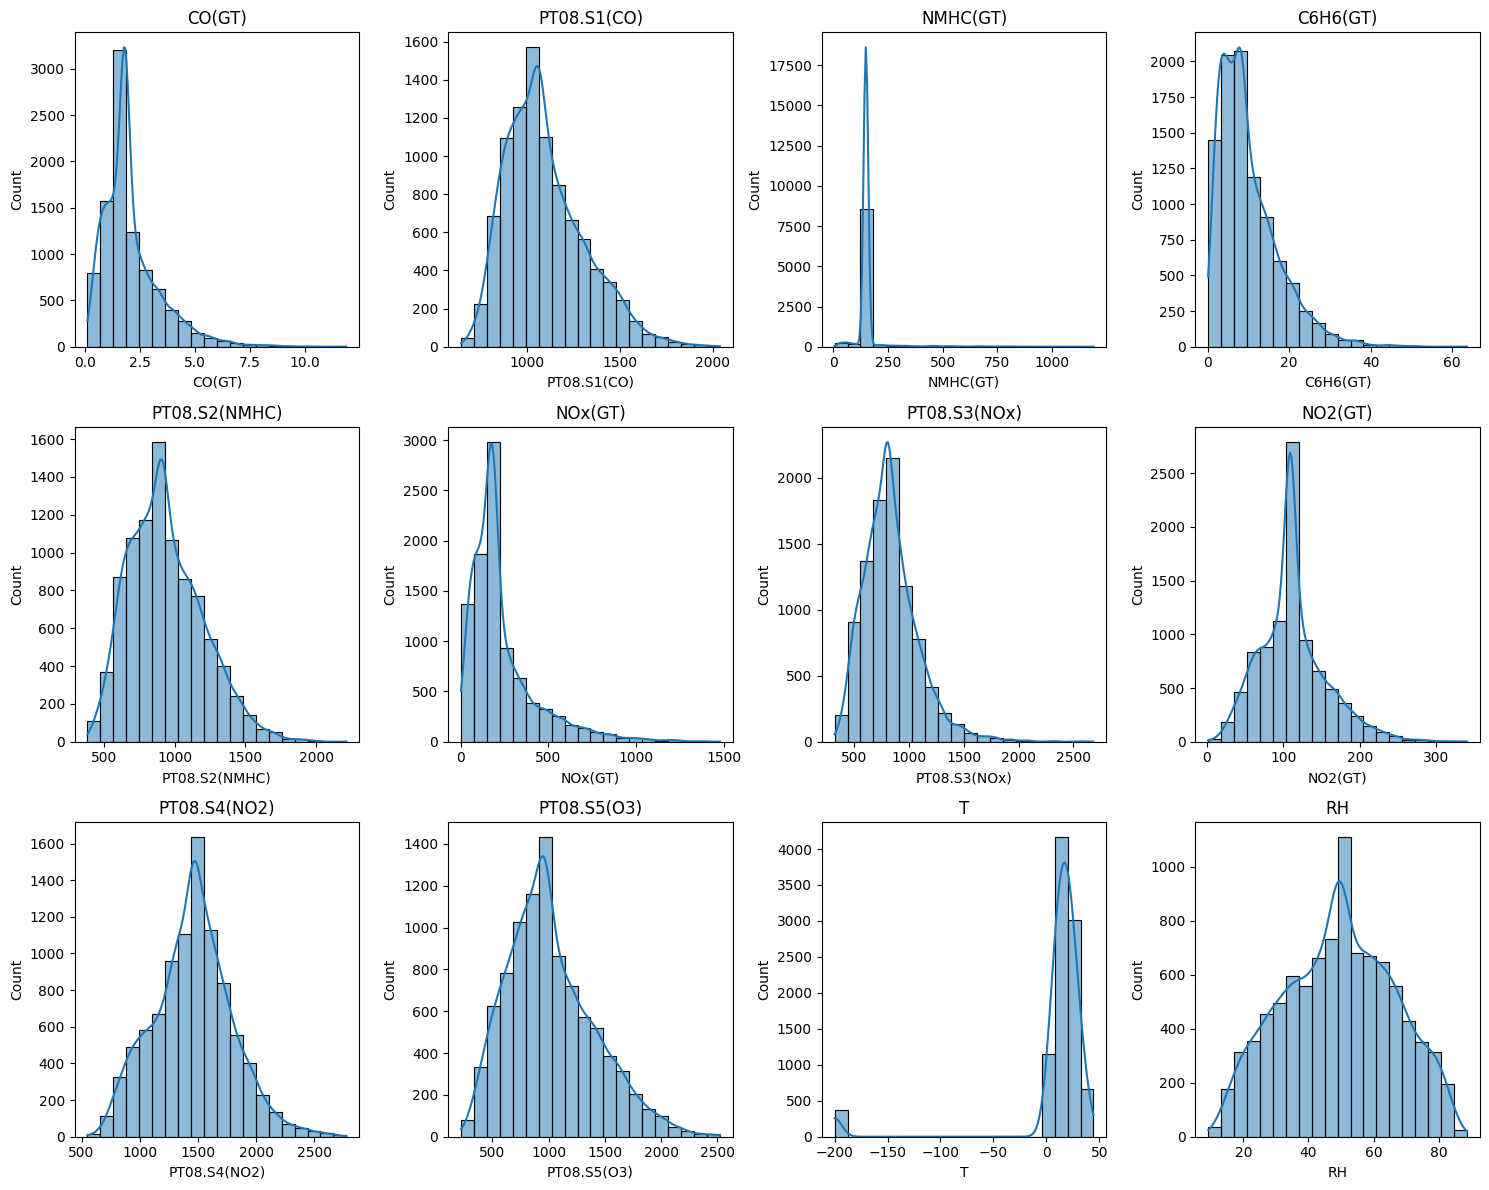

In [ ]:
plot_feature_distributions(data, numeric_columns[:-1])

From the histograms above, it can be concluded that data is very noisy.

-CO(GT) data is right skewed. Meaning the outliers tend to be higher rather than lower. Also, mean is bigger than the median.

-PT08 S1(CO) data is right skewed with the longest tail and its closer to normal distribution than CO(GT).

-NMHC(GT) data has a small range of data with high frequencies focused between 230-250. Assigning smaller weight to this would make model perform better if these aren't strongly correlated with target feature.

-C6H6(GT) is also right skewed and its further to normal distribution than others.

-PT08 S2(NMHC) data is almost similar to PT08 S1(CO) data. So dimension reduction techniques can be applied.

-NOx(GT) data is also right skewed.

-PT08 S3(NOx) data has a shorter tail compared to other PT08 measurements.

-NO2(GT) data is slightly right skewed, making it closer to the normal distribution. Data has high frequency between 100-120.

-PT08 S4(NO2) data can be interpreted as the smoother version of NO2(GT)

-PT08 S5(O3) data is slighty right skewed and has less noise then NO2(GT)

-T data has erroneous values at -200 and they will be handled.

-RH data is normally distributed with data focused in 48-52 bins.

Summary, it can be concluded that the data is very noisy, has outliers and erroneous inputs.

Consequantially, calculating IQR and handling the values that falls over 1.5 * IQR of third quantile or below -1.5 * IQR of first quantile will make them smoother and features will contribute to possible model's performance.

NOTE : Histograms are going to be evaluated one more time after outlier handling.

In [ ]:
for column in numeric_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    bound_condition = (data[column] < lower_bound) | (data[column] > upper_bound)
    data.loc[bound_condition,column] = np.nan
    data[column] = data[column].fillna(data[column].mean())

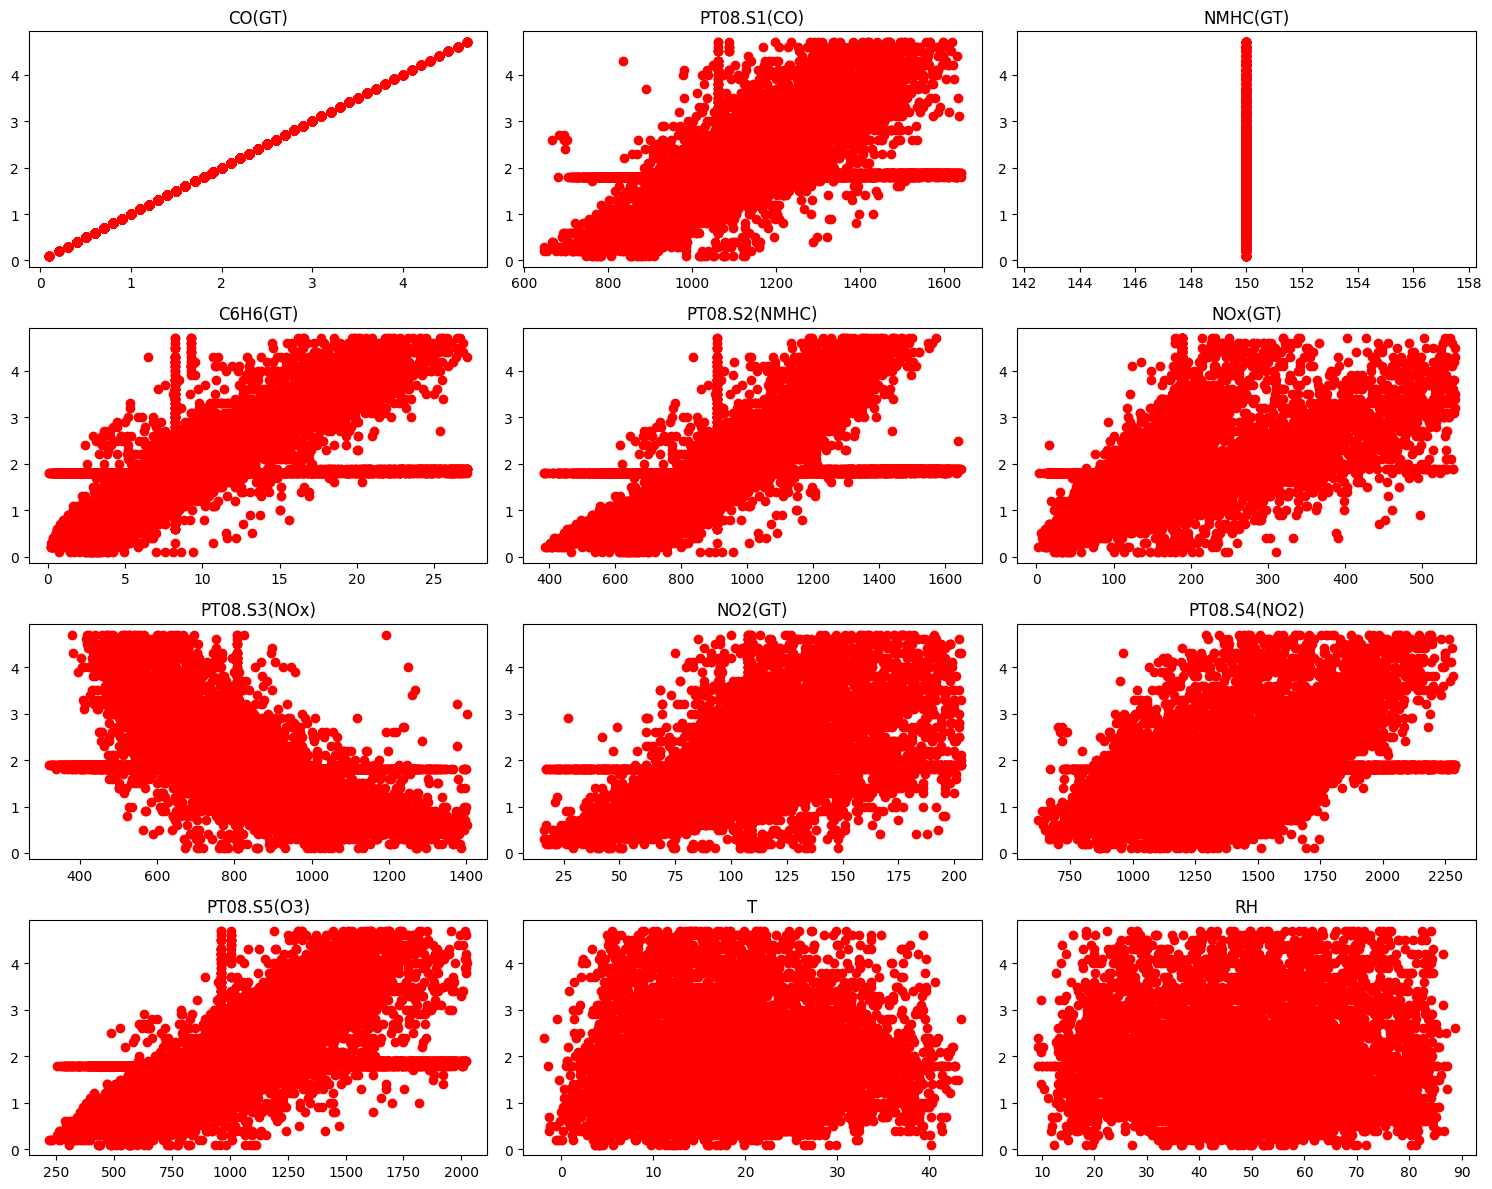

In [ ]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(numeric_columns[:-1]):
    plt.subplot(4, 3, i + 1)
    plt.scatter(data[column], data['CO(GT)'],color = 'Red')
    plt.title(column)
plt.tight_layout()
plt.show()

CO(GT) seems to be positively correlated with almost all features except T,RH and AH so these will be dropped.

NMHC(GT) column seems to be an unstable column, it will be dropped

Date and Time columns will be used in further inspection, for first model trials, they will be dropped too.

In [ ]:
data = data.drop(['T','RH','AH','NMHC(GT)','Date','Time'], axis = 1)

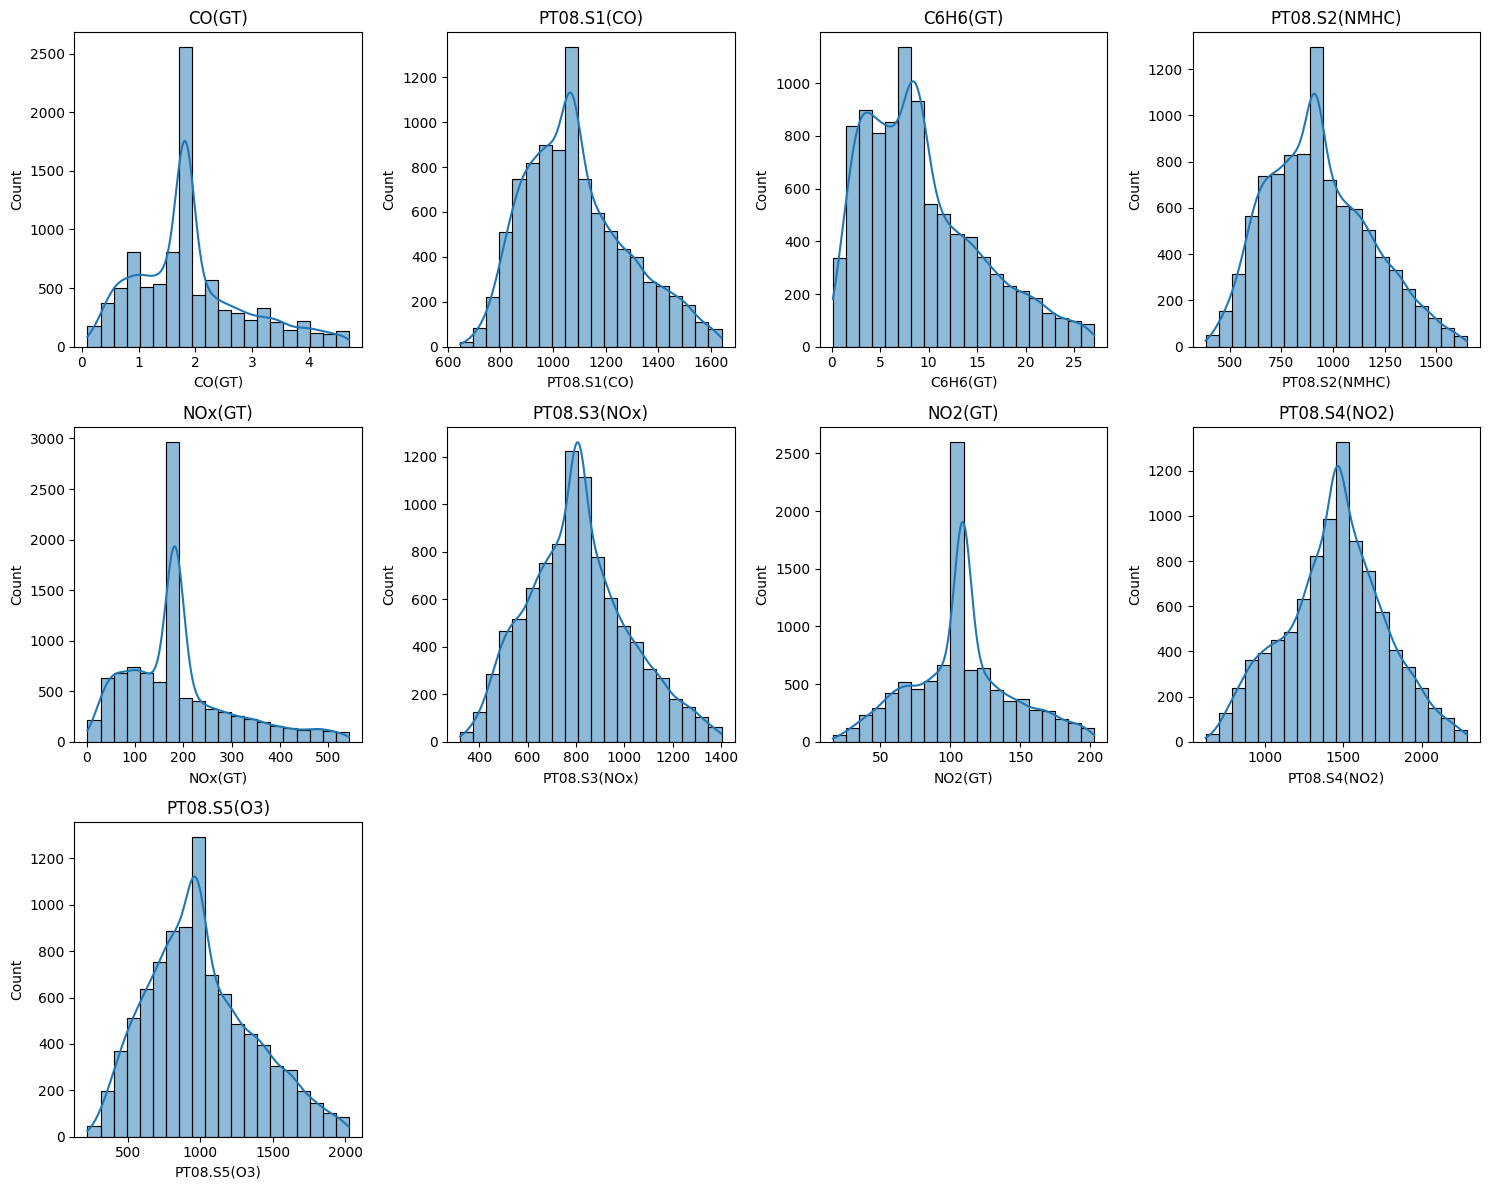

In [ ]:
plot_feature_distributions(data, data.columns)

In [ ]:
data

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0
...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0


After outlier handling, skewness of the distributions are reduced and they are all closer to normal distribution.

(Note that erroneous values in T column are eliminated too while detecting outliers.)

In this stage, the data is more refined and ready to be scaled.

# Scaling and Correlation

Apply Z - Score Normalization to scale the value.

I didn't use Min-Max scaling because data is very noisy.

In [ ]:
scaler = StandardScaler()
cols = data.columns
data = scaler.fit_transform(data)

In [ ]:
sc_data = pd.DataFrame(data, columns = cols)

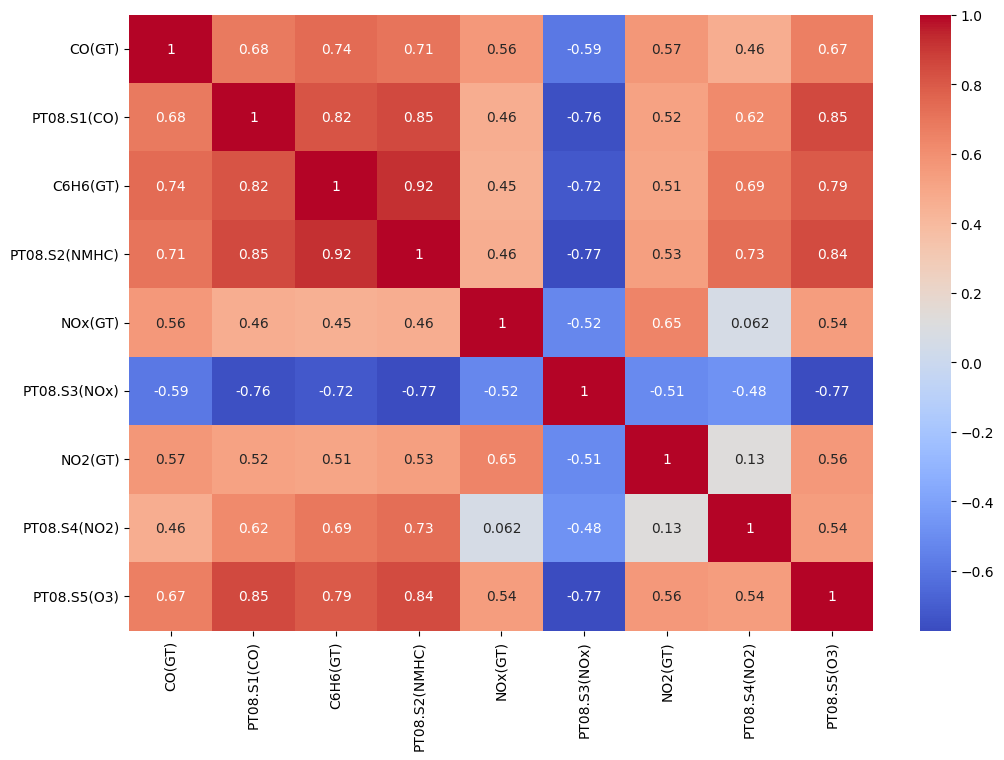

In [ ]:
correlation_matrix = sc_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

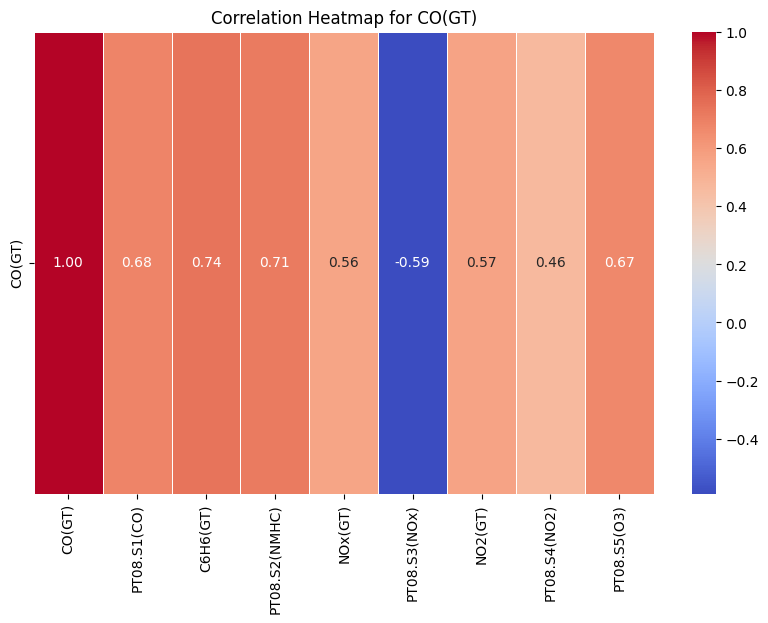

In [ ]:
correlation_matrix = sc_data.corr()
correlation_with_target = correlation_matrix["CO(GT)"]
# Reshape the correlation values to a DataFrame for heatmap
correlation_df = correlation_with_target.to_frame().T

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for CO(GT)')
plt.show()

## Visualize By Seasons

1-1976 -> 2004 Spring

1976-4184 -> 2004 Summer

4184-6368 -> 2024 Fall

6368-8528-> 2024-2025 Winter





In [ ]:
df = sc_data

spring = df[:1976]
summer = df[1976:4184]
fall = df[4184:6368]
winter = df[6368:8528]



In [ ]:
spring

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,0.734750,1.386527,0.438195,0.467707,-0.210619,1.184069,0.142614,0.780144,0.722551
1,0.111505,1.039783,0.019733,0.101203,-0.781288,1.752625,-0.435127,0.362021,-0.087923
2,0.319253,1.600693,-0.047221,0.036762,-0.527657,1.588804,0.170126,0.349446,0.191362
3,0.319253,1.468114,-0.013744,0.073010,-0.156270,1.357527,0.390217,0.440615,0.544575
4,-0.303992,0.937799,-0.465682,-0.378072,-0.527657,1.901992,0.225149,0.145099,0.289933
...,...,...,...,...,...,...,...,...,...
1971,-1.134986,-0.270709,-0.298297,-0.208916,-1.007744,0.803425,-1.067891,0.786432,-0.490421
1972,-1.550483,-0.520569,-0.666544,-0.599585,-1.170792,1.217797,-1.370517,0.594661,-0.851849
1973,-1.342734,-0.362494,-0.465682,-0.386127,-1.161734,0.846790,-1.343006,0.729844,-0.739587
1974,-1.654357,-0.846917,-0.766974,-0.724439,-1.297607,1.323799,-1.728167,0.443759,-0.873754


In [ ]:
print(len(spring))
print(len(summer))
print(len(fall))
print(len(winter))

1976
2208
2184
2160


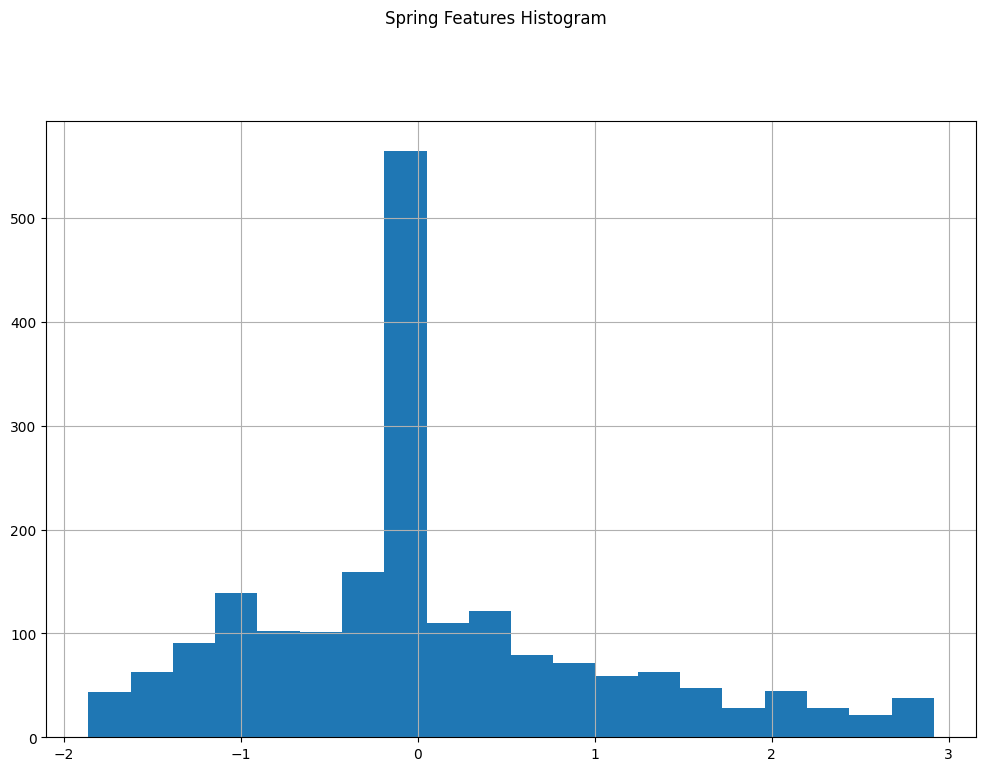

In [ ]:
spring['CO(GT)'].hist(figsize=(12, 8), bins=20)
plt.suptitle('Spring Features Histogram', y=1.02)
plt.show()


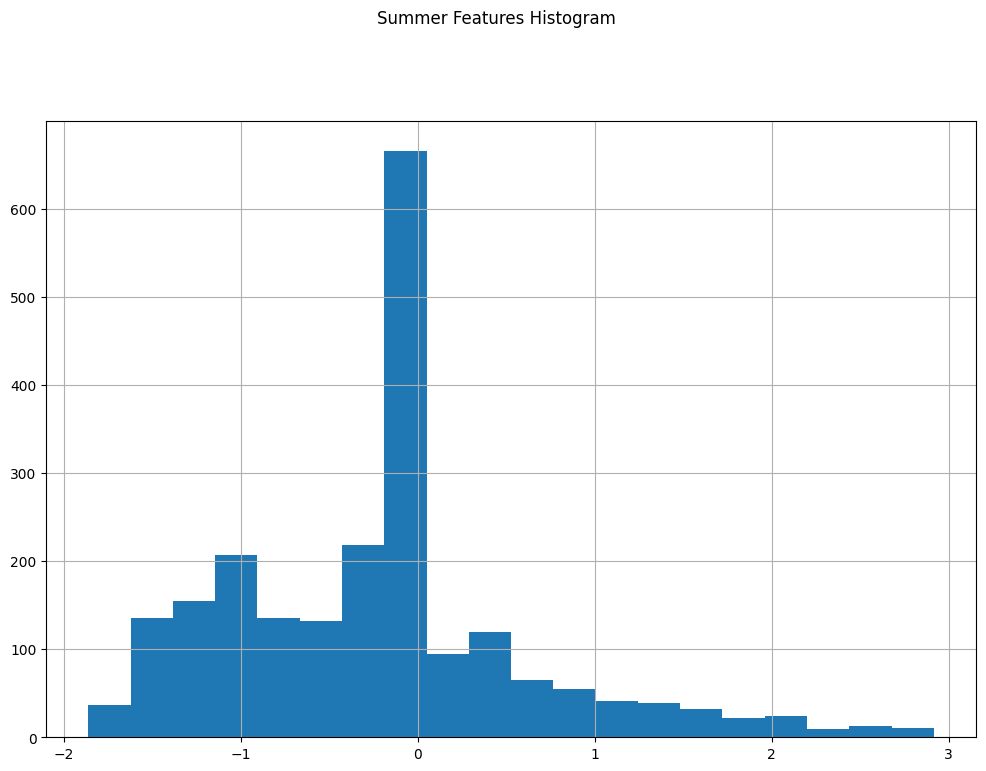

In [ ]:
summer['CO(GT)'].hist(figsize=(12, 8), bins=20)
plt.suptitle('Summer Features Histogram', y=1.02)
plt.show()


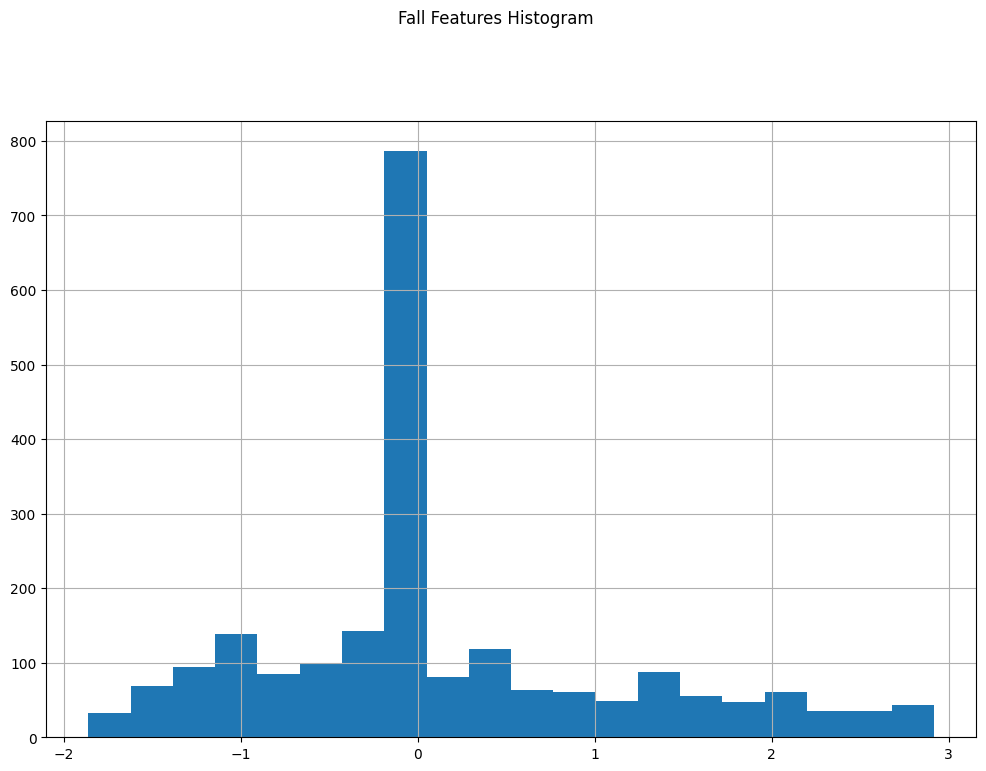

In [ ]:
fall['CO(GT)'].hist(figsize=(12, 8), bins=20)
plt.suptitle('Fall Features Histogram', y=1.02)
plt.show()


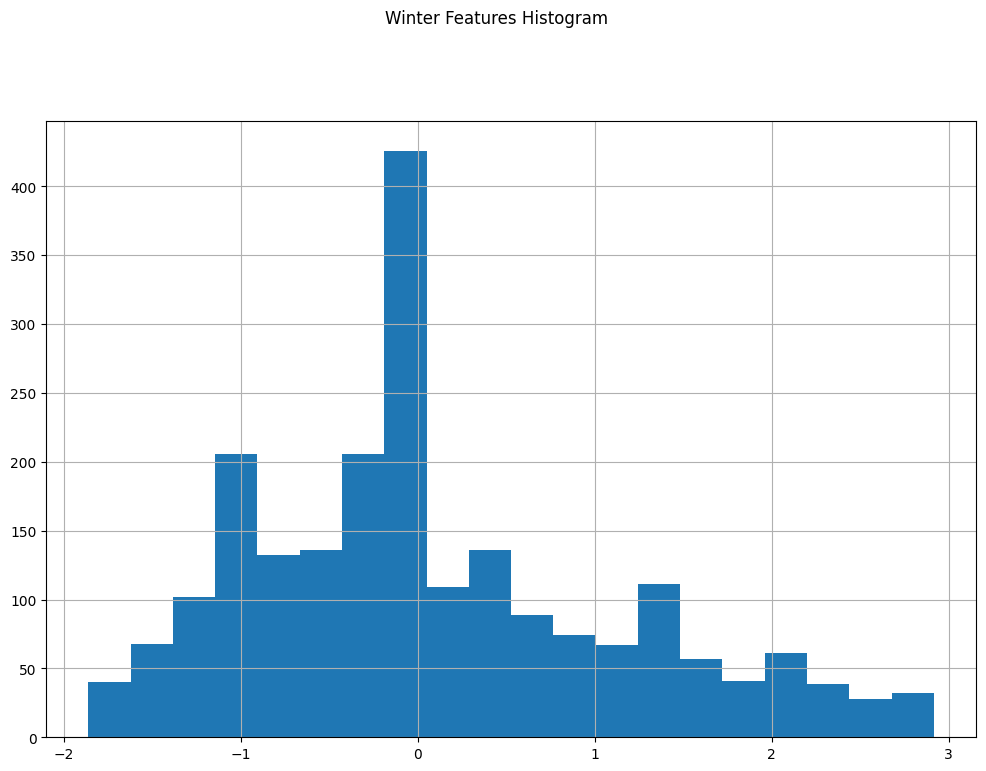

In [ ]:
winter['CO(GT)'].hist(figsize=(12, 8), bins=20)
plt.suptitle('Winter Features Histogram', y=1.02)
plt.show()


### Inspect Variances

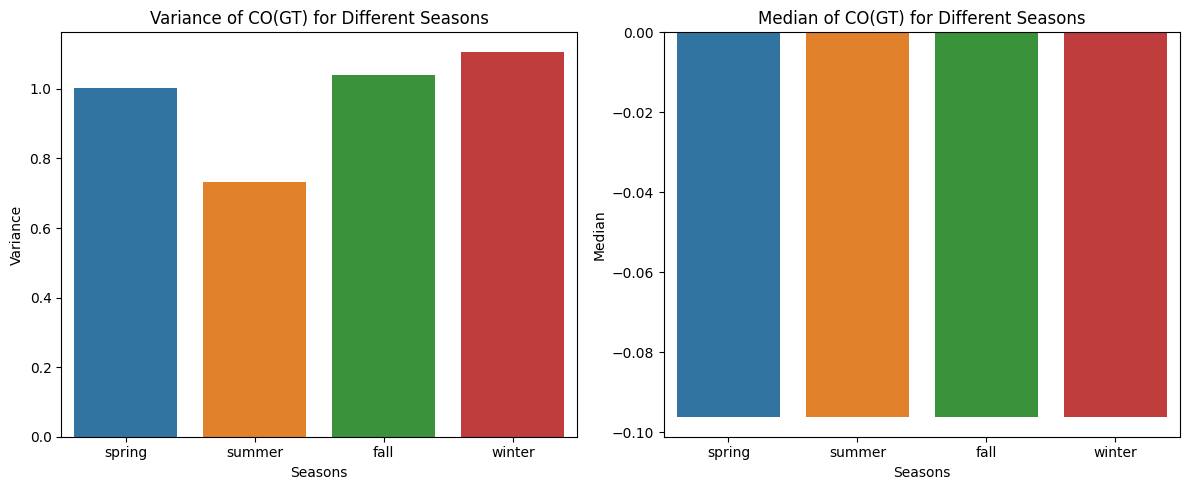

In [ ]:
# Assuming you have the same 'spring', 'summer', 'fall', 'winter' and corresponding medians
medians = [spring['CO(GT)'].median(), summer['CO(GT)'].median(), fall['CO(GT)'].median(), winter['CO(GT)'].median()]

# Data for the histogram
variances = [spring['CO(GT)'].var(), summer['CO(GT)'].var(), fall['CO(GT)'].var(), winter['CO(GT)'].var()]
seasons = ['spring', 'summer', 'fall', 'winter']

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.barplot(x=seasons, y=variances, ax=axes[0])
axes[0].set_title('Variance of CO(GT) for Different Seasons')
axes[0].set_xlabel('Seasons')
axes[0].set_ylabel('Variance')

# Plot the bar plot for medians
sns.barplot(x=seasons, y=medians, ax=axes[1])
axes[1].set_title('Median of CO(GT) for Different Seasons')
axes[1].set_xlabel('Seasons')
axes[1].set_ylabel('Median')

# Adjust layout
plt.tight_layout()
plt.show()

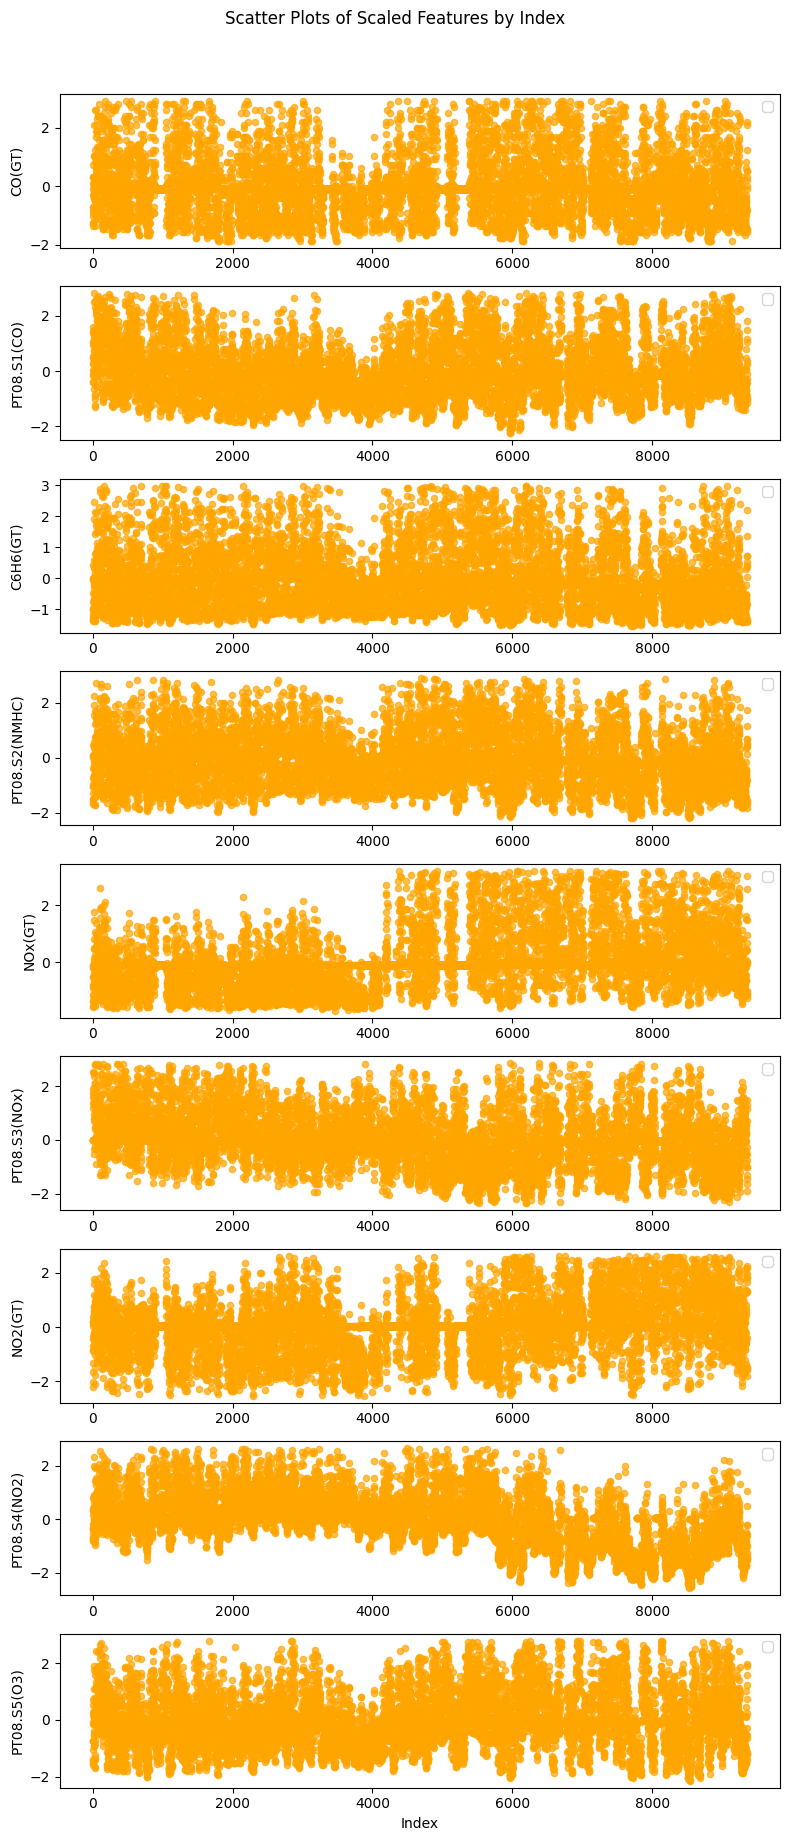

In [ ]:
#Specify the feature columns you want to include in the pair plot
feature_columns = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']


# Create individual scatter plots for each feature
fig, axes = plt.subplots(nrows=len(feature_columns), ncols=1, figsize=(8, 2*len(feature_columns)))

# Loop through each feature column and create a scatter plot
for i, feature in enumerate(feature_columns):
    axes[i].scatter(df.index, df[feature], marker='o', s=20,  alpha=0.7, color = 'orange')
    axes[i].set_ylabel(feature)
    axes[i].legend()

# Set common xlabel
axes[-1].set_xlabel('Index')

plt.suptitle('Scatter Plots of Scaled Features by Index', y=1.02)
plt.tight_layout()
plt.show()

Divide the data into 2 sections, GT and PT08 abd train_test_split them.

# Train & Test Split

In [ ]:
GT_data = sc_data.drop(['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)','CO(GT)'], axis = 1)
PT_data = sc_data.drop(GT_data, axis = 1)
PT_data = PT_data.drop('CO(GT)', axis = 1)

In [ ]:
PT_data

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,1.386527,0.467707,1.184069,0.780144,0.722551
1,1.039783,0.101203,1.752625,0.362021,-0.087923
2,1.600693,0.036762,1.588804,0.349446,0.191362
3,1.468114,0.073010,1.357527,0.440615,0.544575
4,0.937799,-0.378072,1.901992,0.145099,0.289933
...,...,...,...,...,...
9352,1.151965,0.689220,-1.306980,-0.219580,1.984809
9353,0.381987,0.391184,-0.993792,-0.565396,0.725289
9354,0.274904,0.536174,-0.998610,-0.637704,0.240648
9355,-0.433883,0.125368,-0.521601,-1.266461,-0.641016


In [ ]:
GT_train, GT_test, y_train_GT, y_test_GT = train_test_split(GT_data, sc_data['CO(GT)'], test_size=0.2, random_state=42)

In [ ]:
PT_train, PT_test, y_train_PT, y_test_PT = train_test_split(PT_data, sc_data['CO(GT)'], test_size=0.2, random_state=31)

# Machine Learning Models

In [ ]:
def calculate_mape(y_actual, y_predicted):
    # Avoid division by zero by replacing actual values of 0 with a small number
    epsilon = 1e-10
    y_actual_nonzero = np.where(y_actual == 0, epsilon, y_actual)

    # Calculate absolute percentage error for each observation
    absolute_percentage_error = np.abs((y_actual - y_predicted) / y_actual_nonzero)

    # Calculate mean absolute percentage error
    mape = np.mean(absolute_percentage_error) * 100

    return mape

In [ ]:
def plot_x_and_y(x_values, y_values, title, y_label, x_label):
  # Plotting
  plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='Data Points')

  # Adding labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Adding legend
  plt.legend()

  # Display the plot
  plt.show()

## KNN

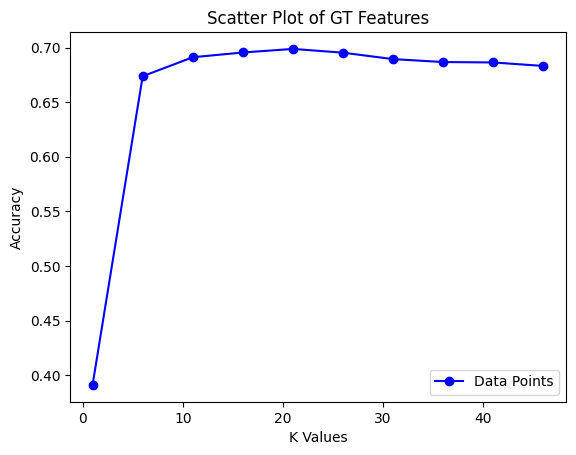

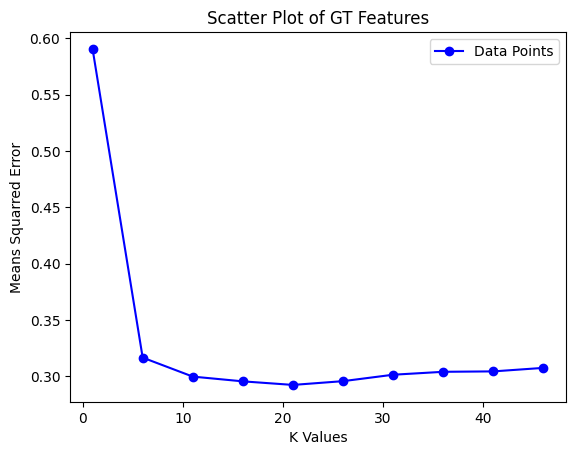

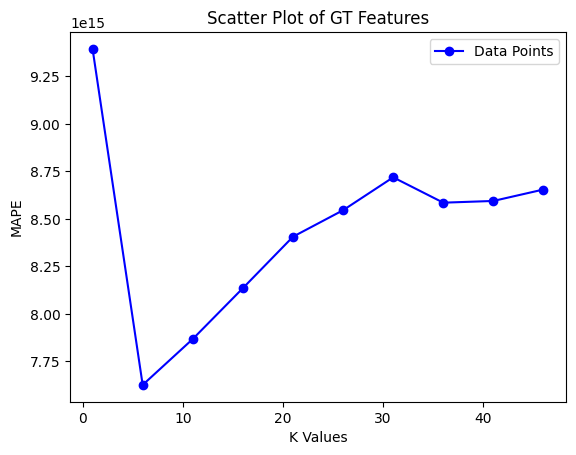

In [ ]:
# Fit kNN to the datasets
k_values = range(1,51,5)
accuracies = []
error = []
mapes = []
for k in k_values:
  model_knn_GT = KNeighborsRegressor(n_neighbors=k)

  knn_GT = model_knn_GT.fit(GT_train, y_train_GT)
  predicted_knn_GT = model_knn_GT.predict(GT_test)
  accuracies.append(knn_GT.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, model_knn_GT.predict(GT_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test_GT, model_knn_GT.predict(GT_test)))


plot_x_and_y(k_values,accuracies,"Scatter Plot of GT Features", "Accuracy","K Values")
plot_x_and_y(k_values,error,"Scatter Plot of GT Features", "Means Squarred Error", "K Values")
plot_x_and_y(k_values,mapes,"Scatter Plot of GT Features", "MAPE", "K Values")


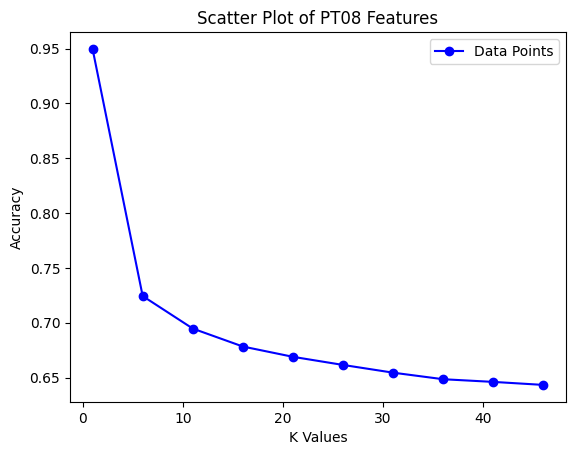

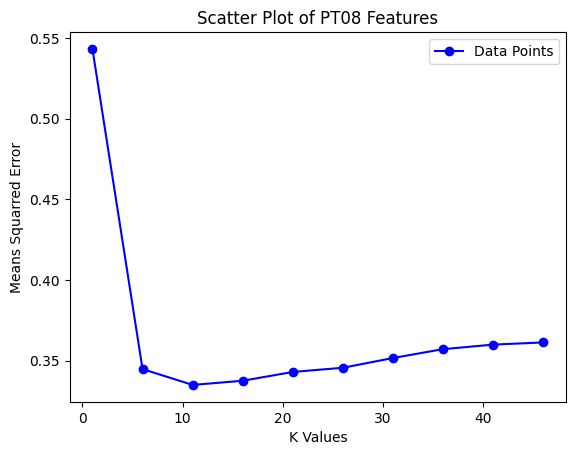

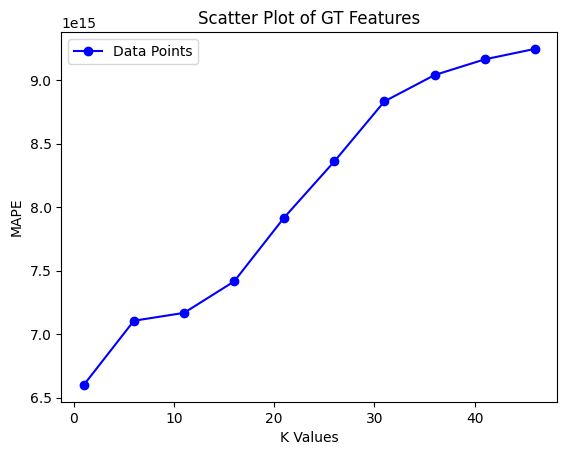

In [ ]:
# Fit kNN to the datasets
k_values = range(1,51,5)
accuracies = []
error = []
mapes = []
for k in k_values:
  model_knn_PT = KNeighborsRegressor(n_neighbors=k)

  knn_PT = model_knn_PT.fit(PT_train, y_train_PT)

  accuracies.append(knn_PT.score(PT_train, y_train_PT))

  mse = mean_squared_error(y_test_PT, knn_PT.predict(PT_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test_PT, knn_PT.predict(PT_test)))

plot_x_and_y(k_values,accuracies,"Scatter Plot of PT08 Features", "Accuracy", "K Values")
plot_x_and_y(k_values,error,"Scatter Plot of PT08 Features", "Means Squarred Error","K Values")
plot_x_and_y(k_values,mapes,"Scatter Plot of GT Features", "MAPE", "K Values")


## Linear Regression

In [ ]:
# Fit Linear Regression to the datasets
model_reg_GT = LinearRegression()
model_reg_PT = LinearRegression()

reg_GT = model_reg_GT.fit(GT_train, y_train_GT)

print(f"Accuracy of Linear Regression with GT is: {reg_GT.score(GT_test, y_test_GT)}")
print(f"MSE of Linear Regression with GT is: {mean_squared_error(y_test_GT, reg_GT.predict(GT_test))}")
print(f"MAPE of Linear Regression with GT is: {calculate_mape(y_test_GT, reg_GT.predict(GT_test))}\n")

reg_PT = model_reg_PT.fit(PT_train, y_train_PT)
print(f"Accuracy of Linear Regression with PT08 is: {reg_PT.score(PT_test, y_test_PT)}")
print(f"MSE of Linear Regression with PT08 is: { mean_squared_error(y_test_PT, reg_PT.predict(PT_test))}")
print(f"MAPE of Linear Regression with PT08 is: { calculate_mape(y_test_PT, reg_PT.predict(PT_test))}")


Accuracy of Linear Regression with GT is: 0.6164035571083382
MSE of Linear Regression with GT is: 0.37208362803605644
MAPE of Linear Regression with GT is: 9426599896887876.0

Accuracy of Linear Regression with PT08 is: 0.5242065402375895
MSE of Linear Regression with PT08 is: 0.44977784651585667
MAPE of Linear Regression with PT08 is: 1.2022167755540986e+16


## SVR

In [ ]:
# Fit SVR to the dataset

C_values =  range(1,100,5)
accuracies = []
error = []
mapes = []

for c in C_values:


  model_svr_PT = make_pipeline(StandardScaler(), SVR(C=c, epsilon=0.2))
  svr_PT = model_svr_PT.fit(PT_train, y_train_PT)
  accuracies.append(svr_PT.score(PT_test, y_test_PT))

  mse = mean_squared_error(y_test_PT, model_svr_PT.predict(PT_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test_PT, model_svr_PT.predict(PT_test)))


plot_x_and_y(C_values,accuracies,"Scatter Plot of PT08 Features", "Accuracy", "C values")
plot_x_and_y(C_values,error,"Scatter Plot of PT08 Features", "Mean Squaarred Error","C Values")
plot_x_and_y(C_values,mapes,"Scatter Plot of PT08 Features", "MAPE","C Values")



KeyboardInterrupt: ignored

In [ ]:
# Fit SVR to the dataset

epsilon_values = [x / 20 for x in range(1,20,2)]
accuracies = []
error = []
mapes = []

for e in epsilon_values:


  model_svr_PT = make_pipeline(StandardScaler(), SVR(C=75, epsilon=e))
  svr_PT = model_svr_PT.fit(PT_train, y_train_PT)
  accuracies.append(svr_PT.score(PT_test, y_test_PT))

  mse = mean_squared_error(y_test_PT, model_svr_PT.predict(PT_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test_PT, model_svr_PT.predict(PT_test)))


plot_x_and_y(epsilon_values,accuracies,"Scatter Plot of PT08 Features", "Accuracy","Epsilon Values")
plot_x_and_y(epsilon_values,error,"Scatter Plot of PT08 Features", "Mean Squaarred Error","Epsilon Values")
plot_x_and_y(epsilon_values,mapes,"Scatter Plot of PT08 Features", "MAPE","Epsilon Values")



In [ ]:
# Fit SVR to the dataset

C_values =  range(1,100,5)
accuracies = []
error = []
mapes = []

for c in C_values:


  model_svr_GT = make_pipeline(StandardScaler(), SVR(C=c, epsilon=0.2))
  svr_GT = model_svr_GT.fit(GT_train, y_train_GT)
  accuracies.append(svr_GT.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, model_svr_GT.predict(GT_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test_GT, model_svr_GT.predict(GT_test)))


plot_x_and_y(C_values,accuracies,"Scatter Plot of GT Features", "Accuracy","C Values")
plot_x_and_y(C_values,error,"Scatter Plot of GT Features", "Mean Squaarred Error","C Values")
plot_x_and_y(C_values,mapes,"Scatter Plot of GT Features", "MAPE","C Values")



In [ ]:
# Fit SVR to the dataset

epsilon_values = [x / 20 for x in range(1,20,2)]
accuracies = []
error = []
mapes = []

for e in epsilon_values:


  model_svr_GT = make_pipeline(StandardScaler(), SVR(C=40, epsilon=e))
  svr_GT = model_svr_GT.fit(GT_train, y_train_GT)
  accuracies.append(svr_GT.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, model_svr_GT.predict(GT_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test_GT, model_svr_GT.predict(GT_test)))


plot_x_and_y(epsilon_values,accuracies,"Scatter Plot of GT Features", "Accuracy","Epsilon Values")
plot_x_and_y(epsilon_values,error,"Scatter Plot of GT Features", "Mean Squaarred Error","Epsilon Values")
plot_x_and_y(epsilon_values,mapes,"Scatter Plot of GT Features", "MAPE","Epsilon Values")



## Decision Tree


In [ ]:
# Initialize the Random Forest Regressor
iterations = range(1,500)
accuracies = []
error = []
mapes = []
for iteration in iterations:
  tree_model = DecisionTreeRegressor()

  # Train the model
  tree_model.fit(GT_train, y_train_GT)

  # Make predictions on the test set
  y_pred = tree_model.predict(GT_test)

  accuracies.append(tree_model.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, tree_model.predict(GT_test))
  error.append(mse)
  mapes.append(calculate_mape(y_test_GT, tree_model.predict(GT_test)))


plot_x_and_y(iterations,accuracies,"Scatter Plot of GT Features", "Accuracy","Iterations")
plot_x_and_y(iterations,error,"Scatter Plot of GT Features", "Mean Squaarred Error","Iterations")
plot_x_and_y(iterations,error,"Scatter Plot of GT Features", "MAPE","Iterations")



In [ ]:
# Initialize the Random Forest Regressor
iterations = range(1,500)
accuracies = []
error = []
mapes = []
for iteration in iterations:
  tree_model = DecisionTreeRegressor()

  # Train the model
  tree_model.fit(PT_train, y_train_PT)

  # Make predictions on the test set
  y_pred = tree_model.predict(PT_test)

  accuracies.append(tree_model.score(PT_test, y_test_PT))

  mse = mean_squared_error(y_test_PT, tree_model.predict(PT_test))
  error.append(mse)
  mapes.append(calculate_mape(y_test_PT, tree_model.predict(PT_test)))

plot_x_and_y(iterations,accuracies,"Scatter Plot of PT08 Features", "Accuracy","Iterations")
plot_x_and_y(iterations,error,"Scatter Plot of PT08 Features", "Mean Squaarred Error","Iterations")
plot_x_and_y(iterations,error,"Scatter Plot of PT08 Features", "MAPE","Iterations")



## Random Forest

In [ ]:
# Initialize the Random Forest Regressor
estimators = range(1,100,10)
accuracies = []
mse = []
mapes = []

for estimator in estimators:
  rf_model = RandomForestRegressor(n_estimators=estimator)

  # Train the model
  rf_model.fit(GT_train, y_train_GT)

  # Make predictions on the test set
  y_pred = rf_model.predict(GT_test)

  accuracies.append(rf_model.score(GT_test, y_test_GT))
  mse.append(mean_squared_error(y_test_GT, rf_model.predict(GT_test)))
  mapes.append(calculate_mape(y_test_GT, rf_model.predict(GT_test)))

plot_x_and_y(estimators,accuracies,"Scatter Plot of GT Features", "Accuracy","Number of Estimator")
plot_x_and_y(estimators,mse,"Scatter Plot of GT Features", "MSE","Number of Estimator")
plot_x_and_y(estimators,mapes,"Scatter Plot of GT Features", "MAPE","Number of Estimator")




In [ ]:
# Initialize the Random Forest Regressor
estimators = range(1,100,10)
accuracies = []
mapes = []
mse = []

for estimator in estimators:
  rf_model = RandomForestRegressor(n_estimators=estimator)

  # Train the model
  rf_model.fit(PT_train, y_train_PT)

  # Make predictions on the test set
  y_pred = rf_model.predict(PT_test)


  accuracies.append(rf_model.score(PT_test, y_test_PT))
  mse.append(mean_squared_error(y_test_PT, rf_model.predict(PT_test)))
  mapes.append(calculate_mape(y_test_PT, rf_model.predict(PT_test)))


plot_x_and_y(estimators,accuracies,"Scatter Plot of PT08 Features", "Accuracy","Number of Estimator")
plot_x_and_y(estimators,mse,"Scatter Plot of PT Features", "MSE","Number of Estimator")
plot_x_and_y(estimators,mapes,"Scatter Plot of PT Features", "MAPE","Number of Estimator")



# Seasonal Machine Learning Models

In [ ]:
spring = sc_data[:1976]
summer = sc_data[1976:4184]
fall = sc_data[4184:6368]
winter = sc_data[6368:8528]


In [ ]:
def calculate_mape(y_actual, y_predicted):
    # Avoid division by zero by replacing actual values of 0 with a small number
    epsilon = 1e-10
    y_actual_nonzero = np.where(y_actual == 0, epsilon, y_actual)

    # Calculate absolute percentage error for each observation
    absolute_percentage_error = np.abs((y_actual - y_predicted) / y_actual_nonzero)

    # Calculate mean absolute percentage error
    mape = np.mean(absolute_percentage_error) * 100

    return mape

In [ ]:
def fit_evaluate(model_call, X_train, y_train, X_test, y_test,first_label = "",second_label= "",third_label= ""):
  model = model_call.fit(X_train, y_train)


  # Divide the test set according to seasons

  X_test_spring = X_test[X_test.index < 1976]
  X_test_summer = X_test[(X_test.index >= 1976) & (X_test.index < 4184)]
  X_test_fall = X_test[(X_test.index >=4184) & (X_test.index < 6368)]
  X_test_winter = X_test[(X_test.index >= 6368) & (X_test.index < 8528)]

  y_test_spring = y_test[y_test.index < 1976]
  y_test_summer = y_test[(y_test.index >= 1976) & (y_test.index < 4184)]
  y_test_fall = y_test[(y_test.index >=4184) & (y_test.index < 6368)]
  y_test_winter = y_test[(y_test.index >= 6368) & (y_test.index < 8528)]

  predicted_spring = model.predict(X_test_spring)
  predicted_summer = model.predict(X_test_summer)
  predicted_fall = model.predict(X_test_fall)
  predicted_winter = model.predict(X_test_winter)

  r2_spring = model.score(X_test_spring, y_test_spring) #Wellness of fit
  r2_summer = model.score(X_test_summer, y_test_summer)
  r2_fall = model.score(X_test_fall, y_test_fall)
  r2_winter = model.score(X_test_winter, y_test_winter)
  r2 = [r2_spring, r2_summer, r2_fall, r2_winter]

  mse_spring = mean_squared_error(y_test_spring, predicted_spring) # Wellness of scaling
  mse_summer = mean_squared_error(y_test_summer, predicted_summer)
  mse_fall = mean_squared_error(y_test_fall, predicted_fall)
  mse_winter = mean_squared_error(y_test_winter, predicted_winter)
  mse = [mse_spring, mse_summer, mse_fall, mse_winter]

  mape_spring = calculate_mape(y_test_spring, predicted_spring) # How model affected by outliers
  mape_summer = calculate_mape(y_test_summer, predicted_summer)
  mape_fall = calculate_mape(y_test_fall, predicted_fall)
  mape_winter = calculate_mape(y_test_winter, predicted_winter)
  mape = [mape_spring, mape_summer, mape_fall, mape_winter]


  seasons = ['spring', 'summer', 'fall', 'winter']

  # Create a 1x2 subplot
  fig, axes = plt.subplots(1, 3, figsize=(15, 8))

  # Plot the histogram



  sns.barplot(x=seasons, y=r2, ax=axes[0])
  axes[0].set_title(first_label)
  axes[0].set_xlabel('Seasons')
  axes[0].set_ylabel('R2 Score')

  sns.barplot(x=seasons, y=mse, ax=axes[1])
  axes[1].set_title(second_label)
  axes[1].set_xlabel('Seasons')
  axes[1].set_ylabel('MSE')


  sns.barplot(x=seasons, y=mape, ax=axes[2])
  axes[2].set_title(third_label)
  axes[2].set_xlabel('Seasons')
  axes[2].set_ylabel('MAPE')

  # Adjust layout
  plt.tight_layout()
  plt.show()

## KNN

kNN on GT data

In [ ]:
fit_evaluate(KNeighborsRegressor(n_neighbors=20), GT_train, y_train_GT, GT_test, y_test_GT, "R2 Scores for GT when k = 20","MSE for GT when k = 20","MAPE for GT when k = 20")

kNN on PT data:

In [ ]:
fit_evaluate(KNeighborsRegressor(n_neighbors=15), PT_train, y_train_PT, PT_test, y_test_PT, "R2 Scores for PT when k = 20","MSE for PT when k = 20","MAPE for PT when k = 20")

## Linear Regression

Linear Regression to GT data:

In [ ]:
fit_evaluate(LinearRegression(), GT_train, y_train_GT, GT_test, y_test_GT, "R2 Scores for GT for Linear Reg","MSE for GT for Linear Reg","MAPE for GT for Linear Reg")

Linear Regression to PT data:

In [ ]:
fit_evaluate(LinearRegression(), PT_train, y_train_PT, PT_test, y_test_PT, "R2 Scores for PT for Linear Reg","MSE for PT for Linear Reg","MAPE for PT for Linear Reg")

## SVR

SVR to GT data:

In [ ]:
fit_evaluate(make_pipeline(StandardScaler(), SVR(C=15, epsilon=0.36)), GT_train, y_train_GT, GT_test, y_test_GT, "R2 for GT for C=15, E=0.36", "MSE for GT for C=15, E=0.36", "MAPE for GT for C=15, E=0.36")

SVR to PT data:

In [ ]:
fit_evaluate(make_pipeline(StandardScaler(), SVR(C=25, epsilon=0.36)), PT_train, y_train_PT, PT_test, y_test_PT, "R2 for PT for C =15, E = 0.36", "MSE for PT for C =15, E = 0.36", "MAPE for PT for C =15, E = 0.36")

## Decision Tree


Decision Tree for GT data:

In [ ]:
fit_evaluate(DecisionTreeRegressor(), GT_train, y_train_GT, GT_test, y_test_GT, "R2 for GT for DTR", "MSE for GT for DTR", "MAPE for GT for DTR")

Decision Tree for PT data:

In [ ]:
fit_evaluate(DecisionTreeRegressor(), PT_train, y_train_PT, PT_test, y_test_PT, "R2 for PT for DTR", "MSE for PT for DTR", "MAPE for PT for DTR")

## Random Forest

Random Forest for GT data:

In [ ]:
fit_evaluate(RandomForestRegressor(n_estimators=35), GT_train, y_train_GT, GT_test, y_test_GT, "R2 for GT for RFR, n = 35", "MSE for GT for  RFR, n = 35", "MAPE  for GT for  RFR, n = 35")

Random Forest for PT data:

In [ ]:
fit_evaluate(RandomForestRegressor(n_estimators=45), PT_train, y_train_PT, PT_test, y_test_PT, "R2 for PT for RFR, n = 45", "MSE for PT for  RFR, n = 45", "MAPE  for PT for  RFR, n = 35")

In [ ]:
spring

In [ ]:
# Set up the matplotlib figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

seasons = [spring, summer, fall, winter]
season_names = ["Spring", "Summer", "Fall", "Winter"]

variable = "CO(GT)"
# Loop through each variable and create a subplot
for i, season in enumerate(seasons):
    df = season

    # Plot histogram with KDE
    sns.histplot(df[variable], kde=True, ax=axes[i], bins=30)

    # Add mean and standard deviation lines
    axes[i].axvline(df[variable].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i].axvline(df[variable].mean() + df[variable].std(), color='green', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
    axes[i].axvline(df[variable].mean() - df[variable].std(), color='green', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')

    axes[i].set_title(season_names[i])
    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
print("Spring " ,spring["CO(GT)"].var())
print("Summer : ",summer["CO(GT)"].var())
print("Fall : ",fall["CO(GT)"].var())
print("Winter : ",winter["CO(GT)"].var())


In [ ]:
spring.columns

In [ ]:
 season[['PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)']]

In [ ]:
# Set up the matplotlib figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

seasons = [spring, summer, fall, winter]
season_names = ["Spring", "Summer", "Fall", "Winter"]

variable = "CO(GT)"
# List to store the sum of absolute correlations for each season
sum_abs_correlations = []

# Loop through each variable and create a subplot
for i, season in enumerate(seasons):
    df = season[["CO(GT)",'PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)']]
    correlation_matrix = df.corr()
    correlation_with_target = correlation_matrix["CO(GT)"]
    # Reshape the correlation values to a DataFrame for heatmap
    correlation_df = correlation_with_target.to_frame().T

    # Plot the heatmap
    sns.heatmap(correlation_df, annot=True, ax=axes[i], cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)  # Remove colorbar

    axes[i].set_title(season_names[i])
    # Add legend
    axes[i].legend()

    # Remove x-axis variable names
    axes[i].set_xticks([])
    axes[i].set_xticklabels([])

    # Calculate and store the sum of absolute correlations for each season
    sum_abs_corr = correlation_with_target.abs().sum()
    sum_abs_correlations.append(sum_abs_corr)

# Display the sum of absolute correlations for each season
for season, sum_abs_corr in zip(season_names, sum_abs_correlations):
    print(f"Sum of Abs Correlations for {season}: {sum_abs_corr / 6}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Set up the matplotlib figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

seasons = [spring, summer, fall, winter]
season_names = ["Spring", "Summer", "Fall", "Winter"]

variable = "CO(GT)"
# List to store the sum of absolute correlations for each season
sum_abs_correlations = []

# Loop through each variable and create a subplot
for i, season in enumerate(seasons):
    df = season[["CO(GT)",'C6H6(GT)','NOx(GT)','NO2(GT)']]
    correlation_matrix = df.corr()
    correlation_with_target = correlation_matrix["CO(GT)"]
    # Reshape the correlation values to a DataFrame for heatmap
    correlation_df = correlation_with_target.to_frame().T

    # Plot the heatmap
    sns.heatmap(correlation_df, annot=True, ax=axes[i], cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)  # Remove colorbar

    axes[i].set_title(season_names[i])
    # Add legend
    axes[i].legend()

    # Remove x-axis variable names
    axes[i].set_xticks([])
    axes[i].set_xticklabels([])

    # Calculate and store the sum of absolute correlations for each season
    sum_abs_corr = correlation_with_target.abs().sum()
    sum_abs_correlations.append(sum_abs_corr)

# Display the sum of absolute correlations for each season
for season, sum_abs_corr in zip(season_names, sum_abs_correlations):
    print(f"Sum of Abs Correlations for {season}: {sum_abs_corr / 4}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Final Model Test

In [ ]:
final_data = data_raw[["CO(GT)","C6H6(GT)","NOx(GT)","NO2(GT)"]]

In [ ]:
scaler = StandardScaler()
cols = final_data.columns
final_data = scaler.fit_transform(final_data)

final_data = pd.DataFrame(final_data, columns = cols)

In [ ]:
X = final_data.drop("CO(GT)",axis = 1)
y = final_data["CO(GT)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


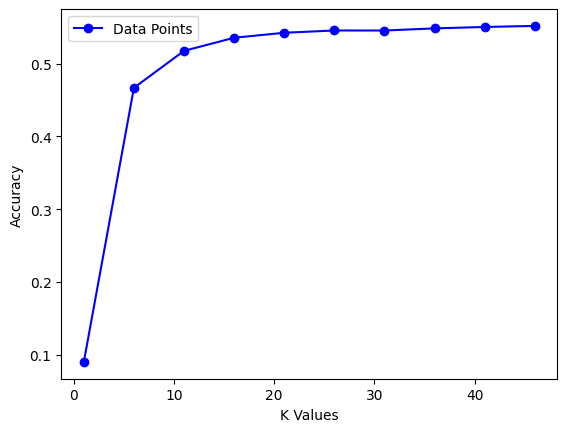

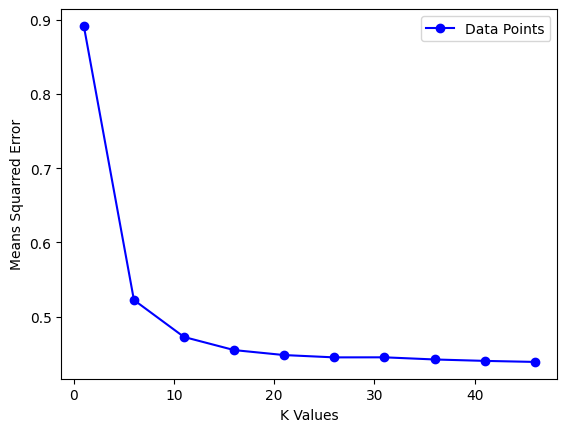

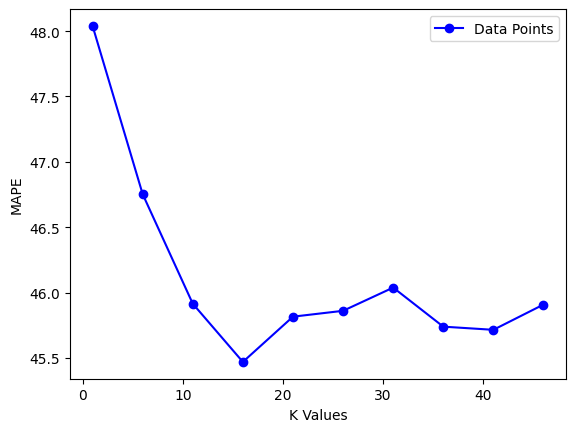

In [ ]:
# Fit kNN to the datasets
k_values = range(1,51,5)
accuracies = []
error = []
mapes = []
for k in k_values:
  model_knn = KNeighborsRegressor(n_neighbors=k)

  knn = model_knn.fit(X_train, y_train)
  predicted_knn = model_knn.predict(X_test)
  accuracies.append(knn.score(X_test, y_test))

  mse = mean_squared_error(y_test, model_knn.predict(X_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test, model_knn.predict(X_test)))


plot_x_and_y(k_values,accuracies,"", "Accuracy","K Values")
plot_x_and_y(k_values,error,"", "Means Squarred Error", "K Values")
plot_x_and_y(k_values,mapes,"", "MAPE", "K Values")


In [ ]:
knn_model = KNeighborsRegressor(n_neighbors= 15)
knn_model.fit(X_train, y_train)


y_test_pred = knn_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test R2 Score : ",knn_model.score(X_test,y_test))
print(f"Test MSE: {mse_test}")

Test R2 Score :  0.535483486937562
Test MSE: 0.45512827701603087


In [ ]:

# Assuming X contains your features and y contains your target variable
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

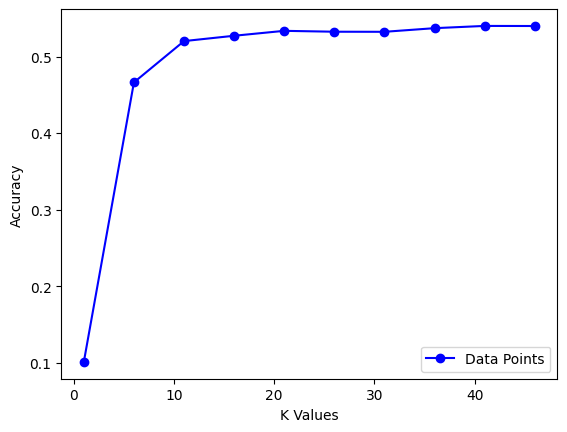

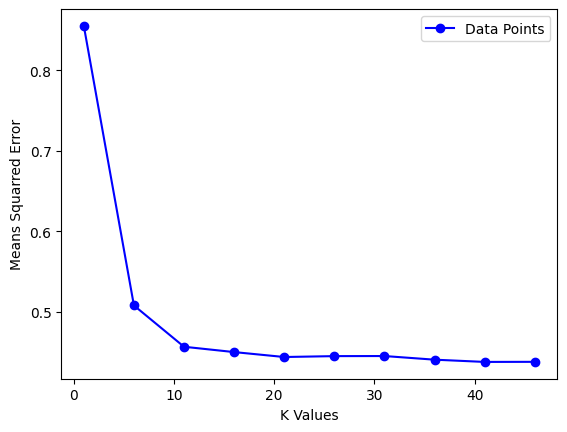

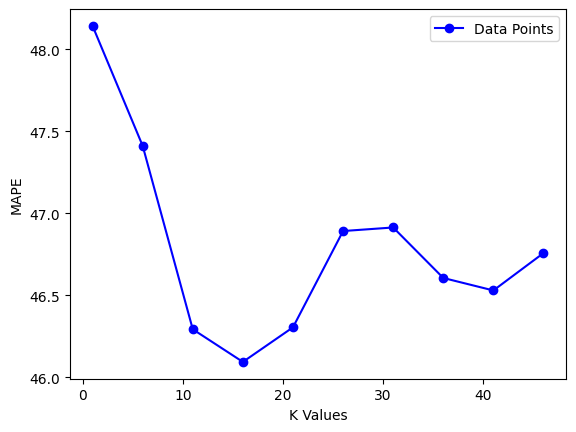

In [ ]:
# Fit kNN to the datasets
k_values = range(1,51,5)
accuracies = []
error = []
mapes = []
for k in k_values:
  model_knn = KNeighborsRegressor(n_neighbors=k)

  knn = model_knn.fit(X_train, y_train)
  predicted_knn = model_knn.predict(X_test)
  accuracies.append(knn.score(X_test, y_test))

  mse = mean_squared_error(y_test, model_knn.predict(X_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test, model_knn.predict(X_test)))


plot_x_and_y(k_values,accuracies,"", "Accuracy","K Values")
plot_x_and_y(k_values,error,"", "Means Squarred Error", "K Values")
plot_x_and_y(k_values,mapes,"", "MAPE", "K Values")


In [ ]:
# Step 5: KNN Model Training
knn_model = KNeighborsRegressor(n_neighbors= 15)
knn_model.fit(X_train, y_train)

# Step 6: Validation
y_val_pred = knn_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"Validation R2 Score : ",knn_model.score(X_val,y_val))
print(f"Validation MSE: {mse_val}\n\n\n")

# Step 7: Testing
y_test_pred = knn_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test R2 Score : ",knn_model.score(X_test,y_test))
print(f"Test MSE: {mse_test}")

Validation R2 Score :  0.5379130946165694
Validation MSE: 0.46556445459196255



Test R2 Score :  0.5326324907320316
Test MSE: 0.44469209944009913


# Imrpove Accuracy

In [ ]:
X = GT_data
y =  sc_data["CO(GT)"]

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge  # Replace with your chosen model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Assume you have features X and labels y
# X, y = ...

# Define your machine learning model with regularization
alpha = 0.1  # Adjust the regularization strength as needed
model = Ridge(alpha=alpha)  # Replace with your chosen model

# Standardize the features (important for regularization)
model_pipeline = make_pipeline(StandardScaler(), model)

# Specify the number of folds for cross-validation
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and print the results
cv_results = cross_val_score(model_pipeline, X, y, cv=kfold, scoring='neg_mean_squared_error')
# Note: Using neg_mean_squared_error as the scoring since Ridge uses a cost function to minimize

# Convert the negative mean squared error back to positive
cv_results = -cv_results

print(f'Cross-Validation MSE: {np.mean(cv_results):.4f} (std: {np.std(cv_results):.4f})')


Cross-Validation MSE: 0.3814 (std: 0.0120)


In [ ]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume you have features X and target variable y (continuous)
# X, y = ...

# Define individual models with regularization (you can adjust parameters as needed)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
knn_model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5))

# Create an ensemble model using VotingRegressor
ensemble_model = VotingRegressor(estimators=[('rf', rf_model), ('knn', knn_model)])

# Specify the number of folds for cross-validation
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Convert r2_score to a scorer
r2_scorer = make_scorer(r2_score)

# Perform cross-validation and print the results
cv_results = cross_val_score(ensemble_model, X, y, cv=kfold, scoring=r2_scorer)

print(f'Ensemble Cross-Validation R2 Score: {np.mean(cv_results):.4f} (std: {np.std(cv_results):.4f})')


Ensemble Cross-Validation R2 Score: 0.6965 (std: 0.0257)


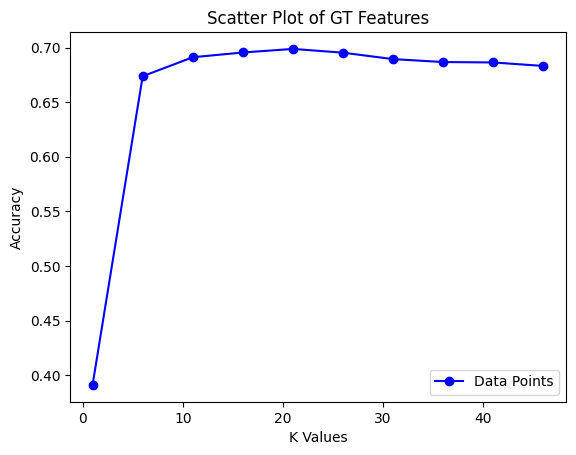

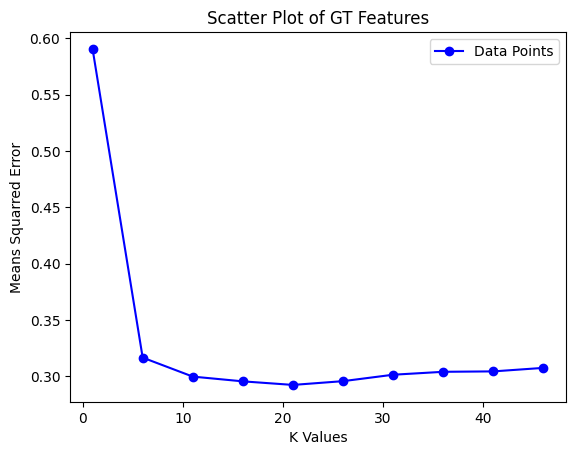

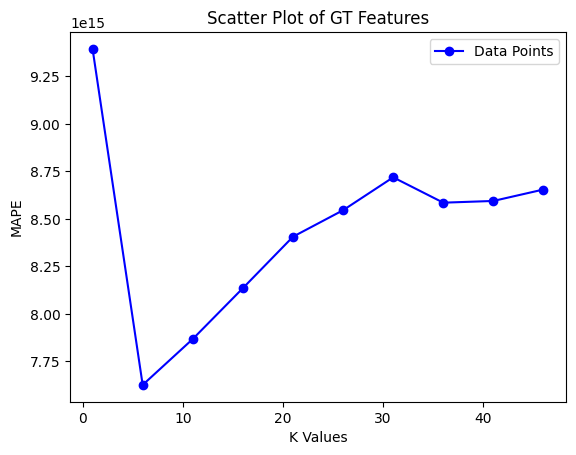

In [ ]:
# Fit kNN to the datasets
k_values = range(1,51,5)
accuracies = []
error = []
mapes = []
for k in k_values:
  model_knn_GT = KNeighborsRegressor(n_neighbors=k)

  knn_GT = model_knn_GT.fit(GT_train, y_train_GT)
  predicted_knn_GT = model_knn_GT.predict(GT_test)
  accuracies.append(knn_GT.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, model_knn_GT.predict(GT_test))
  error.append(mse)

  mapes.append(calculate_mape(y_test_GT, model_knn_GT.predict(GT_test)))


plot_x_and_y(k_values,accuracies,"Scatter Plot of GT Features", "Accuracy","K Values")
plot_x_and_y(k_values,error,"Scatter Plot of GT Features", "Means Squarred Error", "K Values")
plot_x_and_y(k_values,mapes,"Scatter Plot of GT Features", "MAPE", "K Values")
